In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
import edward as ed
import edward.models as edm
from tensorflow.contrib.linalg import LinearOperatorTriL
import itertools
ds = tf.contrib.distributions

In [2]:
D = 2
N = 10**3
cov = np.array([[1, 1.2],[1.2, 2.5]])
X = sps.multivariate_normal.rvs(mean = np.array([1,5]), cov = cov, size=N)

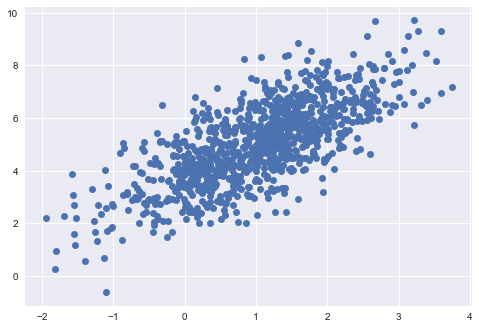

In [3]:
plt.plot(X[:,0],X[:,1],'o')

It is not common to use wishart distribution as a prior.. but let's do this as a baseline

$$\textbf{x}_i\sim\mathcal{MVN}(\boldsymbol{\mu},\boldsymbol{\Sigma})$$

$$\boldsymbol{\mu}|\boldsymbol{\Sigma}\sim\mathcal{MVN}(\mu_0,k_0\boldsymbol{\Sigma})$$

$$\boldsymbol{\Sigma}\sim\text{Wishart}(\nu_0,\boldsymbol{\Psi}_0)$$

In [4]:
# priors
nu0 = tf.Variable(D, dtype=tf.float32, trainable=False)
psi0 = tf.Variable(np.eye(D),
                      dtype=tf.float32, trainable=False)
mu0 = tf.Variable(np.zeros(D), dtype=tf.float32, trainable=False)
k0 = tf.Variable(1., dtype=tf.float32, trainable=False)

In [5]:
sigma = edm.WishartCholesky(df=nu0, scale=psi0,cholesky_input_output_matrices=True)
#sigma = WishartFull(df=v_prior, scale=W_prior, name="psigma")
mu = edm.MultivariateNormalTriL(mu0, k0*sigma)
# tile flatten mu[d] times N,  which, N times D
xn = edm.MultivariateNormalTriL(tf.reshape(tf.tile(mu, [N]), [N, D]),
                            tf.reshape(tf.tile(sigma, [N, 1]), [N, D, D]))


In [6]:
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [7]:
sigma.sample(1).eval()

array([[[ 0.82807511,  0.        ],
        [-1.31973839,  0.55620533]]], dtype=float32)

In [8]:
#qnu0=tf.round(tf.nn.softplus(tf.Variable(tf.random_normal([]))))+D
qpsi0 = tf.Variable(tf.random_normal([D, D], dtype=tf.float32))
Ltril = LinearOperatorTriL(ds.matrix_diag_transform(qpsi0, transform=tf.nn.softplus)).to_dense()
qsigma = edm.WishartCholesky(df=100,scale=Ltril) #,cholesky_input_output_matrices=True)

In [9]:
qmu0 = tf.Variable(tf.random_normal([D], dtype=tf.float32))
qR = tf.Variable(tf.random_normal([D, D], dtype=tf.float32))
qmu = edm.MultivariateNormalTriL(qmu0, qR)

In [10]:
inference3 = ed.KLqp({mu: qmu, sigma: qsigma}, data={xn: X})
inference3.initialize(n_iter=1000, n_print=100, n_samples=30)
sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()



{'t': 1, 'loss': 30894.869}
{'t': 31, 'loss': 4609.5601}
{'t': 61, 'loss': 3016.9592}
{'t': 91, 'loss': 2919.0798}
{'t': 121, 'loss': 2914.5278}
{'t': 151, 'loss': 2924.5601}
{'t': 181, 'loss': 2914.582}
{'t': 211, 'loss': 2957.9241}
{'t': 241, 'loss': 2917.8008}
{'t': 271, 'loss': 2914.7256}
{'t': 301, 'loss': 2911.1003}
{'t': 331, 'loss': 2928.4077}
{'t': 361, 'loss': 2922.8875}
{'t': 391, 'loss': 2910.9629}
{'t': 421, 'loss': 2930.0022}
{'t': 451, 'loss': 2941.1216}
{'t': 481, 'loss': 2908.6716}
{'t': 511, 'loss': 2918.7324}
{'t': 541, 'loss': 2907.4836}
{'t': 571, 'loss': 2914.6218}
{'t': 601, 'loss': 2931.9663}
{'t': 631, 'loss': 2939.0745}
{'t': 661, 'loss': 2908.2207}
{'t': 691, 'loss': 2910.7703}
{'t': 721, 'loss': 2916.9614}
{'t': 751, 'loss': 2921.7312}
{'t': 781, 'loss': 2943.6404}
{'t': 811, 'loss': 2910.7773}
{'t': 841, 'loss': 2914.3391}
{'t': 871, 'loss': 2938.5876}
{'t': 901, 'loss': 2919.4893}
{'t': 931, 'loss': 2950.9092}
{'t': 961, 'loss': 2931.8442}
{'t': 991, 'loss

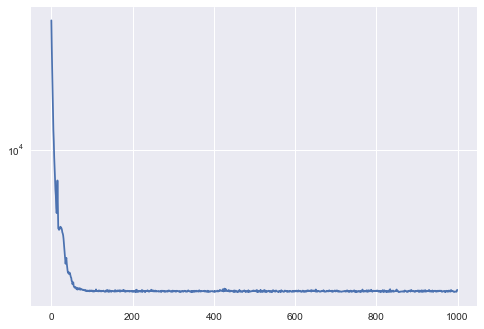

In [11]:
learning_curve3 = []
for _ in range(inference3.n_iter):
    info_dict = inference3.update()
    if _%30 == 0:
        print(info_dict)
    learning_curve3.append(info_dict['loss'])
plt.semilogy(learning_curve3)

In [12]:
qmu0.eval()

array([ 1.00480413,  5.05055475], dtype=float32)

In [13]:
LL=Ltril.eval()

In [14]:
psi_eval=np.matmul(LL,np.transpose(LL))

In [15]:
sps.wishart.rvs(100,psi_eval,100).mean(axis=0)

array([[ 0.95605667,  1.03447328],
       [ 1.03447328,  1.16087938]])

In [16]:
qsigma.sample(100).eval().mean(axis=0)

array([[ 0.96949476,  1.05475414],
       [ 1.05475414,  1.18848944]], dtype=float32)

In [17]:
psi_eval*100 # expectation of wishart distribution  https://en.wikipedia.org/wiki/Wishart_distribution

array([[ 0.97869706,  1.06033921],
       [ 1.06033921,  1.1898452 ]], dtype=float32)

1000

In [18]:
mu_draws=sps.multivariate_normal.rvs(qmu0.eval(),qR.eval(),N)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [19]:
sigma_draws=sps.wishart.rvs(100,psi_eval,N)

In [20]:
x_draws=np.zeros([1000,2])

In [21]:
for i in range(N):
    x_draws[i,:]=sps.multivariate_normal.rvs(mu_draws[i,:],sigma_draws[i,:,:])

In [22]:
x_draws[3,:]

array([ 1.32924913,  3.03419438])

In [23]:
sigma_draws[2,:,:]

array([[ 0.90241317,  0.97416113],
       [ 0.97416113,  1.09321445]])

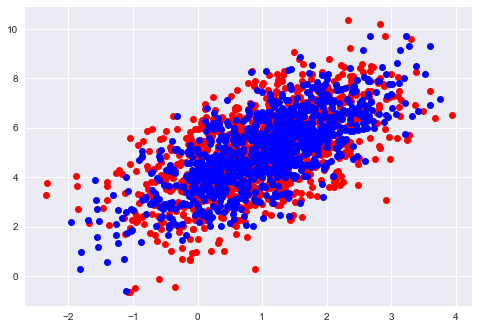

In [24]:
plt.plot(x_draws[:,0],x_draws[:,1],'ro',X[:,0],X[:,1],'bo')